## Data Preparation

### Load and Examine the Data

In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
data = pd.read_csv("7allV03.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB


In [3]:
data.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [4]:
data["category"].unique()

array(['siyaset ', 'dunya ', 'ekonomi ', 'kultur ', 'saglik ', 'spor ',
       'teknoloji '], dtype=object)

In [5]:
from sklearn.utils import shuffle
data = shuffle(data)

In [6]:
data.head()

,category,text
657,siyaset,siyaset 24 te gazze deki gelişmeler tartışıld...
33,siyaset,iktidarın gerçek niyeti ortaya çıktı chp gene...
3347,saglik,kanser ölüm gibi algılanmasın ege üniversites...
3578,spor,tavşanlı_linyitspor 6 haftada kazanamıyor ptt...
3194,saglik,kreşler enfeksiyon okulu uzmanlar çok sık has...


### Remove stopwords and punctuations.

In [7]:
import string
from nltk.corpus import stopwords

def text_preprocess(text):
    nltk_turkish_stopwords = stopwords.words('turkish')
    # remove punctuations
    trans = str.maketrans('', '', string.punctuation)
    text = text.translate(trans)
    # lowercase the text
    text = text.lower()
    # remove stopwords
    cleaned_text = ""
    for word in text.split():
        if word not in nltk_turkish_stopwords:
            cleaned_text += word + " " 
    return cleaned_text

data["text"] = data["text"].apply(text_preprocess)
data.head()

,category,text
657,siyaset,siyaset 24 te gazze deki gelişmeler tartışıldı...
33,siyaset,iktidarın gerçek niyeti ortaya çıktı chp genel...
3347,saglik,kanser ölüm algılanmasın ege üniversitesi tıpf...
3578,spor,tavşanlılinyitspor 6 haftada kazanamıyor ptt 1...
3194,saglik,kreşler enfeksiyon okulu uzmanlar sık hasta ol...


### Generate document embeddings with simple TF-IDF

In [8]:
def retrieve_vectors(data):
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf = TfidfVectorizer().fit_transform(data["text"])
    docvectors = tfidf.toarray()
    return tfidf, docvectors
    
tfidf, docvectors = retrieve_vectors(data)
docvectors.shape

(4900, 110823)

### Calculate similarity with TF-IDF matrix operation

In [9]:
def run_baseline_test(tfidf):
    start = time.time()
    pairwise_similarity = tfidf * tfidf.T
    end = time.time()

    print("time:", end-start)
    pairwise_similarity = pairwise_similarity.toarray()
    pd.DataFrame(pairwise_similarity)

run_baseline_test(tfidf)

time: 1.2298929691314697


## Efficiency Tests

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
def find_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [11]:
import matplotlib.pyplot as plt

def plot_results(data_sizes, run_times, comparisons):
        
    plt.figure(figsize=(9, 3))
    plt.subplots_adjust(left=-0.2)
    
    plt.clf()
    plt.subplot(121)
    plt.plot(data_sizes, run_times)
    plt.title('Data Size vs. Runtime')
    plt.xlabel("Data Size")
    plt.ylabel("Runtime (seconds)")
    plt.grid(True)

    plt.subplot(122)
    plt.plot(data_sizes, comparisons)
    plt.title('Data Size vs. Num. of Comparisons')
    plt.xlabel("Data Size")
    plt.ylabel("Num. of Comparisons")
    plt.grid(True)

### Brute Force Approach

In [12]:
def run_brute_force_test(data_sizes, docvectors):
    brute_force_run_times = []
    brute_force_comparisons = []
    for data_size in data_sizes:
        test_vectors = docvectors[:data_size]
        num_of_comparisons = 0
        pairwise_similarity = []
        
        start = time.time()
        
        for vector_1 in test_vectors[:len(test_vectors) // 2]:
            cur_vector_sims = []
            for vector_2 in test_vectors:
                sim = find_similarity(vector_1, vector_2)
                cur_vector_sims.append(sim)
                num_of_comparisons += 1
            pairwise_similarity.append(cur_vector_sims)

        end = time.time()
        
        time_passed = end-start
        print("data size:", data_size)
        print("time:", time_passed)
        print("number of comparisons:", num_of_comparisons)
        print()

        brute_force_run_times.append(time_passed)
        brute_force_comparisons.append(num_of_comparisons)

    return brute_force_run_times, brute_force_comparisons, pairwise_similarity
        
data_sizes = list(range(100, 1001, 100))
bf_run_times_1, bf_comparisons_1, pairwise_similarity = run_brute_force_test(data_sizes, docvectors)

data size: 100
time: 1.1430072784423828
number of comparisons: 5000

data size: 200
time: 3.0304391384124756
number of comparisons: 20000

data size: 300
time: 4.136618614196777
number of comparisons: 45000

data size: 400
time: 7.2477569580078125
number of comparisons: 80000

data size: 500
time: 11.011485815048218
number of comparisons: 125000

data size: 600
time: 16.350457668304443
number of comparisons: 180000

data size: 700
time: 21.349534511566162
number of comparisons: 245000

data size: 800
time: 28.57096552848816
number of comparisons: 320000

data size: 900
time: 36.08497762680054
number of comparisons: 405000

data size: 1000
time: 44.66091275215149
number of comparisons: 500000



In [13]:
pd.DataFrame(pairwise_similarity)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,0.030284,0.014926,0.014985,0.011524,0.012213,0.004010,0.016707,0.017703,0.036577,...,0.026206,0.011356,0.015357,0.051688,0.003843,0.028996,0.016654,0.028646,0.009634,0.026096
1,0.030284,1.000000,0.010589,0.004128,0.006837,0.003421,0.014496,0.033948,0.007540,0.019388,...,0.020787,0.008922,0.002696,0.026056,0.005000,0.007314,0.012573,0.007887,0.008684,0.006667
2,0.014926,0.010589,1.000000,0.005911,0.066990,0.001383,0.008362,0.018110,0.010244,0.010474,...,0.048265,0.003682,0.004853,0.008811,0.001282,0.006432,0.003451,0.012800,0.000943,0.049206
3,0.014985,0.004128,0.005911,1.000000,0.004894,0.003325,0.004619,0.005745,0.000717,0.008290,...,0.008139,0.001974,0.062788,0.004427,0.023657,0.017096,0.002444,0.008355,0.001429,0.004044
4,0.011524,0.006837,0.066990,0.004894,1.000000,0.003146,0.006294,0.012147,0.011771,0.014432,...,0.028924,0.002321,0.008146,0.017999,0.003642,0.018871,0.001863,0.023569,0.001127,0.005257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.056320,0.039059,0.022636,0.014295,0.024128,0.019254,0.006687,0.033016,0.016803,0.021545,...,0.027547,0.016873,0.010105,0.046819,0.005203,0.022216,0.006917,0.026545,0.007469,0.010547
496,0.011986,0.013786,0.000000,0.003755,0.006644,0.006655,0.003049,0.005810,0.012597,0.009807,...,0.002596,0.007772,0.015732,0.001534,0.003116,0.001341,0.010069,0.007580,0.018406,0.013630
497,0.004429,0.003070,0.000000,0.003174,0.000000,0.006342,0.000000,0.021434,0.012879,0.001702,...,0.000000,0.013088,0.004117,0.005674,0.000000,0.002251,0.006611,0.004608,0.001758,0.002195
498,0.007467,0.011611,0.029621,0.011721,0.001725,0.010933,0.002047,0.018206,0.000748,0.009151,...,0.004513,0.005492,0.009613,0.009090,0.011662,0.002389,0.007399,0.004844,0.001951,0.003779


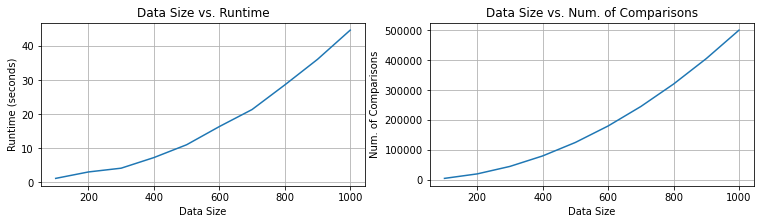

In [14]:
plot_results(data_sizes, bf_run_times_1, bf_comparisons_1)

### Similarity Comparison with Inverted Indexes

In [15]:
def generate_inverted_index(data: list):
    inv_idx_dict = {}
    for index, doc_text in enumerate(data):
        for word in doc_text.split():
            if word not in inv_idx_dict.keys():
                inv_idx_dict[word] = [index]
            elif index not in inv_idx_dict[word]:
                inv_idx_dict[word].append(index)
    return inv_idx_dict

In [16]:
def run_inverted_index_test(data_sizes, data, docvectors):
    data_sizes = list(range(100, 1001, 100))

    inv_idx_run_times = []
    inv_idx_comparisons = []
    for data_size in data_sizes:
        test_vectors = docvectors[:data_size]
        test_data = data["text"].iloc[:data_size].tolist()
        num_of_comparisons = 0
        pairwise_similarity = []
        inv_idx_dict = generate_inverted_index(test_data)
        
        start = time.time()    

        for cur_doc_index, doc in enumerate(test_data):
            to_compare_indexes = [] 
            # find all the document indexes that have a common word with the current doc
            for word in doc.split():
                to_compare_indexes.extend(inv_idx_dict[word])

            # eliminate duplicates
            to_compare_indexes = list(set(to_compare_indexes))

            # calculate the similarity onlf if the id is larger than 
            # the current document id for better efficiency
            cur_doc_sims = []
            for compare_doc_index in to_compare_indexes:
                if compare_doc_index < cur_doc_index:
                    continue
                sim = find_similarity(test_vectors[cur_doc_index], test_vectors[compare_doc_index])
                num_of_comparisons += 1
                cur_doc_sims.append([compare_doc_index, sim])
            pairwise_similarity.append(cur_doc_sims)

        end = time.time()
        
        time_passed = end-start
        print("data size:", data_size)
        print("time:", time_passed)
        print("number of comparisons:", num_of_comparisons)
        print()

        inv_idx_run_times.append(time_passed)
        inv_idx_comparisons.append(num_of_comparisons)
        
    return inv_idx_run_times, inv_idx_comparisons, pairwise_similarity
        
data_sizes = list(range(100, 1001, 100))
ii_run_times_1, ii_comparisons_1, pairwise_similarity = run_inverted_index_test(data_sizes, data, docvectors)

data size: 100
time: 0.47629785537719727
number of comparisons: 4926

data size: 200
time: 2.0175087451934814
number of comparisons: 19364

data size: 300
time: 4.13585638999939
number of comparisons: 43420

data size: 400
time: 7.398017406463623
number of comparisons: 76550

data size: 500
time: 11.417935371398926
number of comparisons: 119448

data size: 600
time: 16.224296808242798
number of comparisons: 172410

data size: 700
time: 20.788417100906372
number of comparisons: 235186

data size: 800
time: 36.17097592353821
number of comparisons: 306869

data size: 900
time: 40.01149821281433
number of comparisons: 388800

data size: 1000
time: 56.29753041267395
number of comparisons: 479647



In [17]:
pd.DataFrame(pairwise_similarity)

,0,1,2,3,4,5,6,7,8,9,...,981,982,983,984,985,986,987,988,989,990
0,"[0, 1.0]","[1, 0.030283574245175127]","[2, 0.014925608912614146]","[3, 0.01498490048281329]","[4, 0.01152386763646272]","[5, 0.012213097245979536]","[6, 0.004010313538573995]","[7, 0.01670739689049964]","[8, 0.017703354340973063]","[9, 0.036576809483155344]",...,"[992, 0.015357092394140192]","[993, 0.05168809242247209]","[994, 0.003843395206793393]","[995, 0.028995598032290876]","[996, 0.01665413500758892]","[997, 0.028645899639202662]","[998, 0.00963375068736634]","[999, 0.0260962698963297]",None,None
1,"[1, 1.0]","[2, 0.01058888190956726]","[3, 0.00412773778310705]","[4, 0.006837445401267251]","[5, 0.003421109761149813]","[6, 0.014495848882817195]","[7, 0.033947884217910396]","[8, 0.007540427703614745]","[9, 0.01938786334320759]","[10, 0.03181707911447402]",...,"[998, 0.008683820128577787]","[999, 0.006667391498271046]",None,None,None,None,None,None,None,None
2,"[2, 1.0000000000000002]","[3, 0.0059105967803188605]","[4, 0.06699013355237834]","[5, 0.0013834656812223426]","[6, 0.008362163169687863]","[7, 0.01810953390955536]","[8, 0.010243713280523054]","[9, 0.010474426617686198]","[10, 0.0018490641724268789]","[11, 0.04405141771565958]",...,None,None,None,None,None,None,None,None,None,None
3,"[3, 1.0]","[4, 0.004893651810895848]","[5, 0.0033253071092180226]","[6, 0.004619487561279478]","[7, 0.005745390451397854]","[8, 0.0007171613117624798]","[9, 0.00829044968372646]","[10, 0.03127805114073101]","[11, 0.013981999602194003]","[12, 0.01572401744093734]",...,"[990, 0.00813923001438769]","[991, 0.001974224391033823]","[992, 0.06278773016800668]","[993, 0.004427279937835811]","[994, 0.02365744108384778]","[995, 0.017096203452868955]","[996, 0.0024441793305237038]","[997, 0.008355064652474235]","[998, 0.0014290281976339597]","[999, 0.004044139586668432]"
4,"[4, 1.0000000000000002]","[5, 0.0031461698685319424]","[6, 0.006294341615109635]","[7, 0.012147330486838961]","[8, 0.011771013664726876]","[9, 0.01443191108923841]","[10, 0.003344457776895899]","[11, 0.01822734216180591]","[12, 0.025479419789937566]","[13, 0.007642706096592501]",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"[995, 1.0]","[996, 0.005421537741355567]","[997, 0.02322354872593325]","[998, 0.013983781926507888]","[999, 0.005748488587179073]",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
996,"[996, 1.0]","[997, 0.017861691223046688]","[998, 0.0037179034356829396]","[999, 0.004916214757386743]",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
997,"[997, 1.0]","[998, 0.0058799880584854145]","[999, 0.01718942557930453]",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
998,"[998, 1.0000000000000002]","[999, 0.02038172435111928]",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


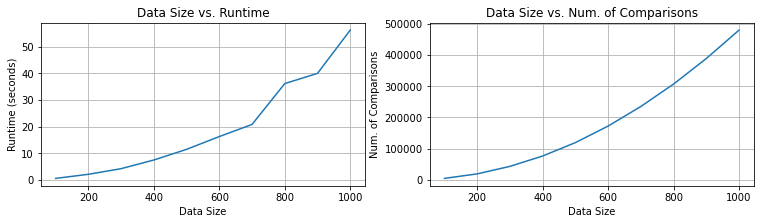

In [18]:
plot_results(data_sizes, ii_run_times_1, ii_comparisons_1)

## Extract top 50 TF-IDF words from each document and try again

In [19]:
# ref: https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.YCrDUlMzaV4

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [20]:
# ref: https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.YCrDUlMzaV4

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

   
def simplify_data(data):
    nltk_turkish_stopwords = stopwords.words('turkish')
    cv = CountVectorizer(max_df=0.85)
    word_count_vector = cv.fit_transform(data["text"].tolist())
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    def tfidf_top50(text):
        feature_names=cv.get_feature_names()
        tf_idf_vector = tfidf_transformer.transform(cv.transform([text]))
        sorted_items = sort_coo(tf_idf_vector.tocoo())
        keywords = extract_topn_from_vector(feature_names,sorted_items, 50)
        new_text = ""
        for keyword in keywords:
            new_text += keyword + " "
        return new_text
    
    data["text"] = data["text"].apply(tfidf_top50)
    return data

In [21]:
# shorten the data to save some time
shorter_data = data.iloc[:1001]
simplified_data = simplify_data(shorter_data)

<ipython-input-20-4d9db47368f8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text"] = data["text"].apply(tfidf_top50)


In [22]:
tfidf, docvectors = retrieve_vectors(simplified_data)
run_baseline_test(tfidf)

time: 0.005913257598876953


### Brute Force 2nd Test

data size: 100
time: 0.3643953800201416
number of comparisons: 5000

data size: 200
time: 1.242382287979126
number of comparisons: 20000

data size: 300
time: 2.647634267807007
number of comparisons: 45000

data size: 400
time: 4.379725456237793
number of comparisons: 80000

data size: 500
time: 6.945195913314819
number of comparisons: 125000

data size: 600
time: 9.679497718811035
number of comparisons: 180000

data size: 700
time: 13.460182189941406
number of comparisons: 245000

data size: 800
time: 17.490578174591064
number of comparisons: 320000

data size: 900
time: 22.326410055160522
number of comparisons: 405000

data size: 1000
time: 37.096956729888916
number of comparisons: 500000



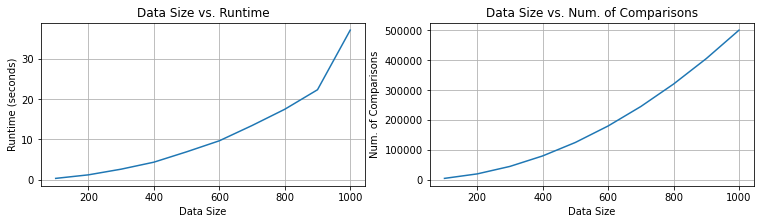

In [23]:
data_sizes = list(range(100, 1001, 100))
bf_run_times_2, bf_comparisons_2, pairwise_similarity = run_brute_force_test(data_sizes, docvectors)
plot_results(data_sizes, bf_run_times_2, bf_comparisons_2)

### Inverted Indexes 2nd Test

data size: 100
time: 0.5436279773712158
number of comparisons: 1433

data size: 200
time: 0.9943344593048096
number of comparisons: 4940

data size: 300
time: 0.8479599952697754
number of comparisons: 9923

data size: 400
time: 1.3799855709075928
number of comparisons: 17748

data size: 500
time: 1.7292485237121582
number of comparisons: 27537

data size: 600
time: 2.8027725219726562
number of comparisons: 38602

data size: 700
time: 3.791750431060791
number of comparisons: 53947

data size: 800
time: 6.232722282409668
number of comparisons: 72516

data size: 900
time: 7.668490886688232
number of comparisons: 92577

data size: 1000
time: 9.655778408050537
number of comparisons: 111832



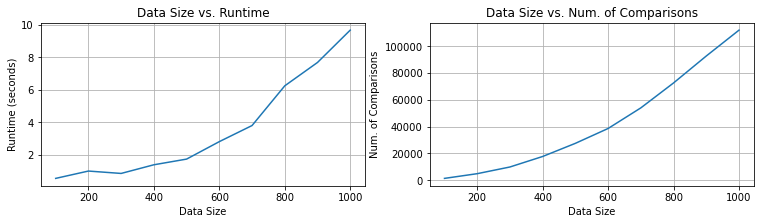

In [24]:
data_sizes = list(range(100, 1001, 100))
ii_run_times_2, ii_comparisons_2, pairwise_similarity = run_inverted_index_test(data_sizes, simplified_data, docvectors)
plot_results(data_sizes, ii_run_times_2, ii_comparisons_2)

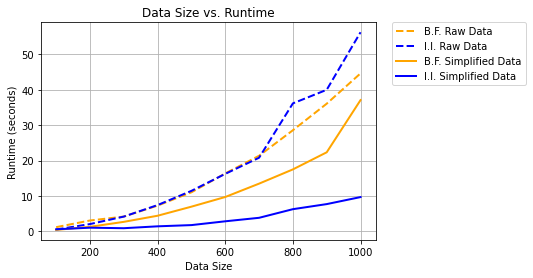

In [38]:
plt.clf()
plt.plot(data_sizes, bf_run_times_1, "--", linewidth=2, color="orange", label="B.F. Raw Data")
plt.plot(data_sizes, ii_run_times_1, "--", linewidth=2, color="blue", label="I.I. Raw Data")
plt.plot(data_sizes, bf_run_times_2, linewidth=2, color="orange", label="B.F. Simplified Data")
plt.plot(data_sizes, ii_run_times_2, linewidth=2, color="blue", label="I.I. Simplified Data")

plt.title('Data Size vs. Runtime')
plt.xlabel("Data Size")
plt.ylabel("Runtime (seconds)")
plt.grid(True)

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

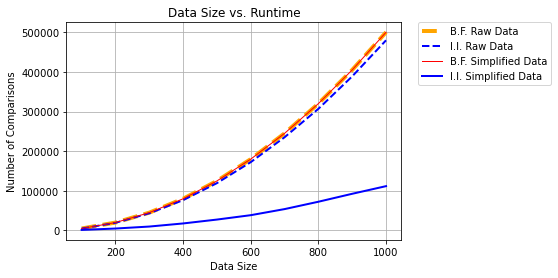

In [54]:
plt.clf()

plt.plot(data_sizes, bf_comparisons_1, "--", linewidth=4,color="orange", label="B.F. Raw Data")
plt.plot(data_sizes, ii_comparisons_1, "--", linewidth=2, color="blue", label="I.I. Raw Data")
plt.plot(data_sizes, bf_comparisons_2, linewidth=1, color="red", label="B.F. Simplified Data")
plt.plot(data_sizes, ii_comparisons_2, linewidth=2, color="blue", label="I.I. Simplified Data")

plt.title('Data Size vs. Runtime')
plt.xlabel("Data Size")
plt.ylabel("Number of Comparisons")
plt.grid(True)

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Last Comments

With raw data, there were no significant gain neither in number of comparisons nor runtime. After data cleaning, number of comparisons did not change for the bruteforce approach, however inverted index approach has significantly improved both in speed and number of comparisons.


The results shows that inverted index only useful if the documents are short, or very distinct. To do this, data reduction might be useful.